## IMPORT LIBRARIES

In [18]:
# Import libraries
import pandas as pd
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
pd.set_option('max_colwidth', 500)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

## READ DATA AND MERGE

In [19]:
b = pd.read_csv("/content/aibl_apoeres_01-Jun-2018.csv")
c = pd.read_csv("/content/aibl_cdr_01-Jun-2018.csv")
d = pd.read_csv("/content/aibl_labdata_01-Jun-2018.csv")
e = pd.read_csv("/content/aibl_medhist_01-Jun-2018.csv")
f = pd.read_csv("/content/aibl_mmse_01-Jun-2018.csv")
g = pd.read_csv("/content/aibl_neurobat_01-Jun-2018.csv")
h = pd.read_csv("/content/aibl_pdxconv_01-Jun-2018.csv")
i= pd.read_csv("/content/aibl_ptdemog_01-Jun-2018.csv")


In [20]:
# list of dataframes  to merge
data_frames = [h,g,c,d,f]

data1 = reduce(lambda  left,right: pd.merge(left,right,on=['RID', 'SITEID', 'VISCODE'],
                                            how='outer'), data_frames)

In [21]:
# list of dataframes  to merge
data_frames = [i,b,e]

data2 = reduce(lambda  left,right: pd.merge(left,right,on=['RID', 'SITEID', 'VISCODE'],
                                            how='outer'), data_frames)

In [22]:
data2.drop(['SITEID', 'VISCODE'],axis  =1,inplace  = True)

In [23]:
data  = pd.merge(data1,data2,on=['RID'])

In [24]:
data.drop(["EXAMDATE_x","EXAMDATE_y"], axis  = 1,inplace  = True)

In [25]:
df = data.copy()

In [26]:
df.shape

(1688, 36)

In [27]:
df.DXCURREN.unique()

array([ 1,  3,  2, -4,  7])

In [28]:
df.DXCURREN.value_counts()

 1    1231
 2     246
 3     204
-4       4
 7       3
Name: DXCURREN, dtype: int64

## 204 people with AD
## 246 people with Mild Cognitive Impairment (MCI) 
## 1231 solid people without intellectual hindrance(HC).

## DATA CLEANING AND PREPROCESSING

In [29]:
df.PTDOB = df.PTDOB.astype(str).apply(lambda x : x.split("/")[1])

In [30]:
df["age"] = 2021 - df.PTDOB.astype(int)

In [31]:
df.PTGENDER.unique(),df.DXCURREN.unique()

(array([1, 2]), array([ 1,  3,  2, -4,  7]))

In [32]:
df = df[df.DXCURREN != -4]
df = df[df.DXCURREN != 7]

In [33]:
def target(x):
  if x == 1:
    return "HC"
  else:
    return "NON HC"

In [34]:
df.DXCURREN = df.DXCURREN.apply(target)

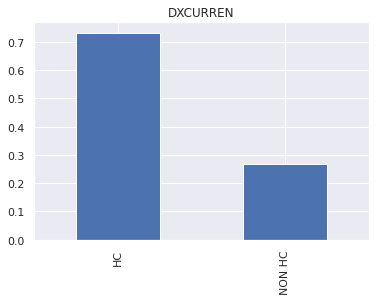

In [35]:
df['DXCURREN'].value_counts(normalize  = True).plot.bar(title='DXCURREN')

The  plot  above shows that there is class bias in the provided data-set:  73% of the individuals were in the healthy control 27% were in the non healthy control group.

In [36]:
df.describe()

,RID,SITEID,LIMMTOTAL,LDELTOTAL,CDGLOBAL,AXT117,BAT126,HMT3,HMT7,HMT13,HMT40,HMT100,HMT102,RCT6,RCT11,RCT20,RCT392,MMSCORE,PTGENDER,APGEN1,APGEN2,MHPSYCH,MH2NEURL,MH4CARD,MH6HEPAT,MH8MUSCL,MH9ENDO,MH10GAST,MH12RENA,MH16SMOK,MH17MALI,age
count,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.00000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000
mean,652.140988,1.320642,10.872100,9.270672,0.193337,1.592319,437.932905,4.078388,5.413742,216.522903,13.146877,29.465318,32.111719,35.664242,87.462264,196.138340,0.628958,27.443783,1.519929,3.245687,2.801309,0.116597,0.05235,0.330161,-0.038667,0.403926,0.063058,0.190363,-0.051755,-0.851279,0.083284,84.289709
std,481.894041,0.466862,5.032366,5.545260,0.474445,1.836253,264.218630,1.909150,2.689930,79.722291,4.126900,7.873090,8.359293,13.542494,25.595099,61.898537,1.066813,3.908853,0.499751,1.044125,0.975179,0.828491,0.64706,0.820772,0.593861,0.818220,0.731647,0.801444,0.685087,2.088919,0.685018,7.094008
min,2.000000,1.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,1.000000,-4.000000,-4.000000,-4.000000,-4.00000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,64.000000
25%,232.000000,1.000000,8.000000,5.000000,0.000000,1.010000,298.181000,4.180000,4.800000,183.000000,13.100000,30.200000,33.600000,30.035000,82.874000,173.993000,0.701000,27.000000,1.000000,3.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.000000,79.000000
50%,572.000000,1.000000,11.000000,10.000000,0.000000,1.600000,399.834000,4.470000,5.600000,220.000000,13.900000,31.200000,34.000000,35.441000,88.278000,201.058000,0.826000,29.000000,2.000000,3.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,84.000000
75%,1024.000000,2.000000,14.000000,13.000000,0.500000,2.400000,528.594000,4.760000,6.600000,260.000000,14.800000,32.100000,34.400000,42.049000,97.286000,231.990000,0.973000,30.000000,2.000000,4.000000,3.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,89.000000
max,1639.000000,2.000000,24.000000,23.000000,3.000000,12.660000,2033.056000,6.060000,22.100000,875.000000,18.100000,39.000000,36.000000,115.334000,234.208000,367.317000,2.093000,30.000000,2.000000,4.000000,4.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,106.000000


In [37]:
df.columns

Index(['RID', 'SITEID', 'VISCODE', 'DXCURREN', 'LIMMTOTAL', 'LDELTOTAL',
       'CDGLOBAL', 'AXT117', 'BAT126', 'HMT3', 'HMT7', 'HMT13', 'HMT40',
       'HMT100', 'HMT102', 'RCT6', 'RCT11', 'RCT20', 'RCT392', 'EXAMDATE',
       'MMSCORE', 'PTGENDER', 'PTDOB', 'APTESTDT', 'APGEN1', 'APGEN2',
       'MHPSYCH', 'MH2NEURL', 'MH4CARD', 'MH6HEPAT', 'MH8MUSCL', 'MH9ENDO',
       'MH10GAST', 'MH12RENA', 'MH16SMOK', 'MH17MALI', 'age'],
      dtype='object')

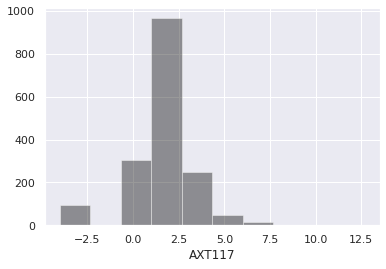

In [38]:
sns.distplot(df["AXT117"],kde =False,color  = "black" ,bins  =10)

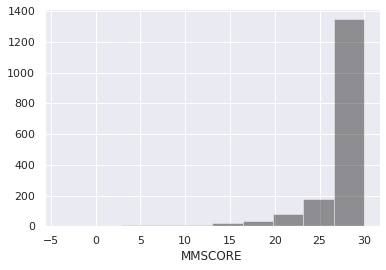

In [39]:
sns.distplot(df["MMSCORE"],kde =False,color  = "black" ,bins  =10)

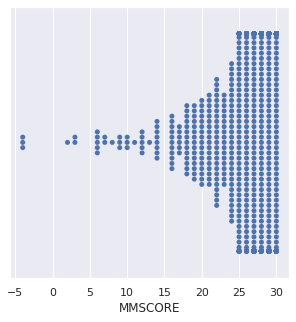

In [40]:
sns.set(rc = {"figure.figsize" :(5,5)})
sns.swarmplot(x = df["MMSCORE"])

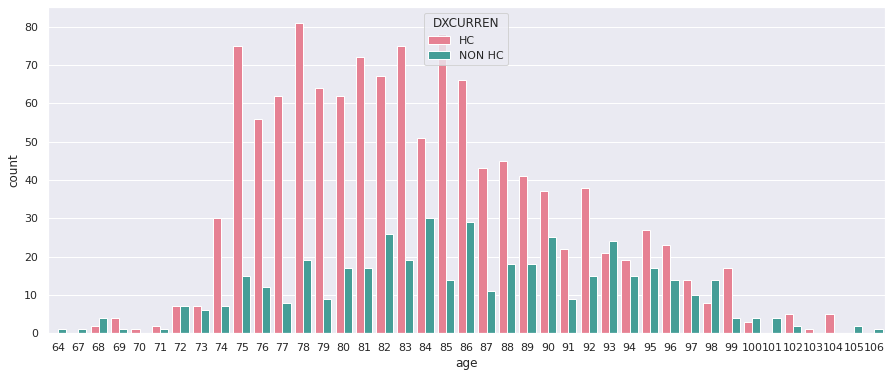

In [41]:
plt.figure(figsize=(15,6))
sns.countplot(x='age',data = df, hue = 'DXCURREN',palette='husl')
plt.show()

In [42]:
df.DXCURREN.value_counts()

HC        1231
NON HC     450
Name: DXCURREN, dtype: int64

In [43]:
df.columns

Index(['RID', 'SITEID', 'VISCODE', 'DXCURREN', 'LIMMTOTAL', 'LDELTOTAL',
       'CDGLOBAL', 'AXT117', 'BAT126', 'HMT3', 'HMT7', 'HMT13', 'HMT40',
       'HMT100', 'HMT102', 'RCT6', 'RCT11', 'RCT20', 'RCT392', 'EXAMDATE',
       'MMSCORE', 'PTGENDER', 'PTDOB', 'APTESTDT', 'APGEN1', 'APGEN2',
       'MHPSYCH', 'MH2NEURL', 'MH4CARD', 'MH6HEPAT', 'MH8MUSCL', 'MH9ENDO',
       'MH10GAST', 'MH12RENA', 'MH16SMOK', 'MH17MALI', 'age'],
      dtype='object')

In [44]:
def target(x):
  if x == "HC":
    return 0
  else:
    return 1
df.DXCURREN = df.DXCURREN.apply(target)

In [45]:
df.DXCURREN.unique()

array([0, 1])

In [46]:
# bar drawing function
def bar_chart(feature):
    Demented = df[df['DXCURREN']==0][feature].value_counts()
    Nondemented = df[df['DXCURREN']==1][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['HC','NON HC']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))

Text(0.5, 1.0, 'Gender and az rate')

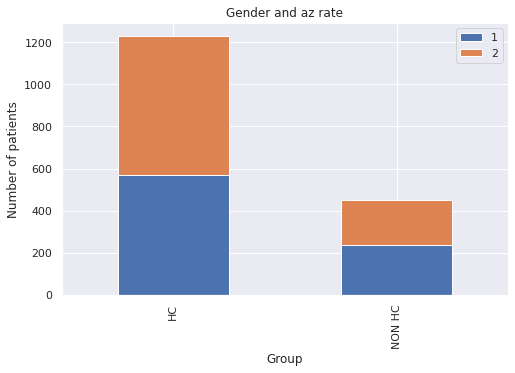

In [47]:
# Gender  and  Group ( Femal=1, Male=2)
bar_chart('PTGENDER')
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and az rate')

(15.3, 2033.056)

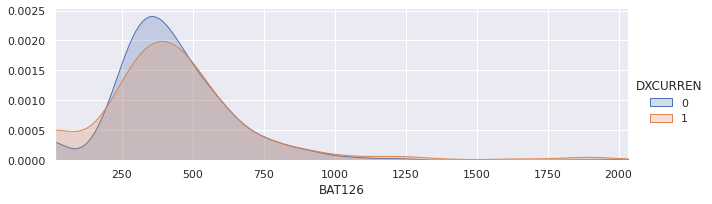

In [48]:
facet= sns.FacetGrid(df,hue="DXCURREN", aspect=3)
facet.map(sns.kdeplot,'BAT126',shade= True)
facet.set(xlim=(0, df['BAT126'].max()))
facet.add_legend()
plt.xlim(15.30)

(15.3, 367.31699999999995)

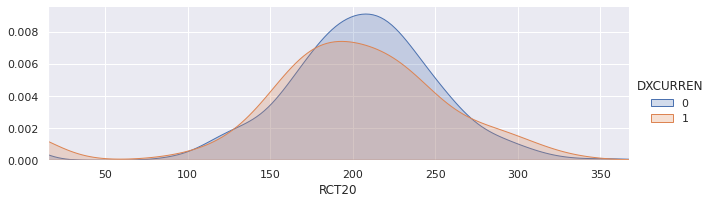

In [49]:
facet= sns.FacetGrid(df,hue="DXCURREN", aspect=3)
facet.map(sns.kdeplot,'RCT20',shade= True)
facet.set(xlim=(0, df['RCT20'].max()))
facet.add_legend()
plt.xlim(15.30)

(15.3, 30.0)

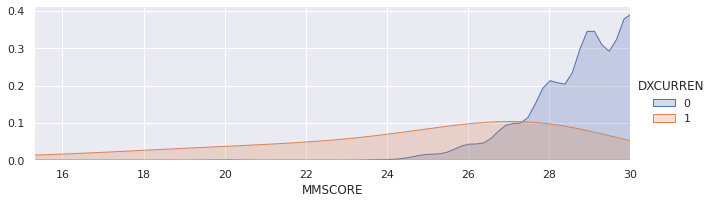

In [50]:
#MMSE : Mini Mental State Examination
facet= sns.FacetGrid(df,hue="DXCURREN", aspect=3)
facet.map(sns.kdeplot,'MMSCORE',shade= True)
facet.set(xlim=(0, df['MMSCORE'].max()))
facet.add_legend()
plt.xlim(15.30)

# The chart shows HEALTHY CONTROL group got much more higher MMSE scores than AD AND MCI group.

(50.0, 100.0)

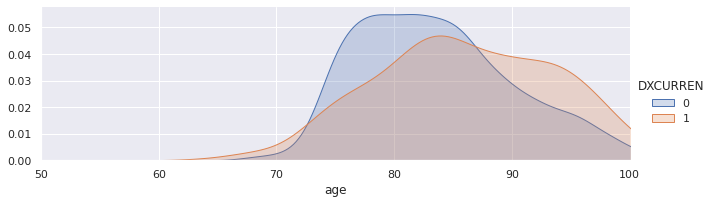

In [51]:

facet= sns.FacetGrid(df,hue="DXCURREN", aspect=3)
facet.map(sns.kdeplot,'age',shade= True)
facet.set(xlim=(0, df['age'].max()))
facet.add_legend()
plt.xlim(50,100)

# There is a higher concentration of 90 -100 years old in the mci and AD 
# patient group than those in the nondemented patients. We guess patients 
# who suffered from that kind of disease has lower survival
#  rate so that there are a few of 90 years old.

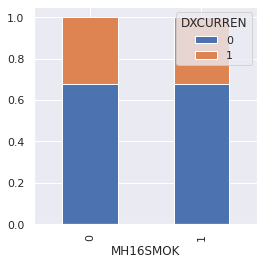

In [52]:
a = df[df.MH16SMOK != -4]
Rh=pd.crosstab(a['MH16SMOK'],a['DXCURREN'])
Rh.div(Rh.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.show()

# this chart shows that smoking doesnt really have an effect on our target variable

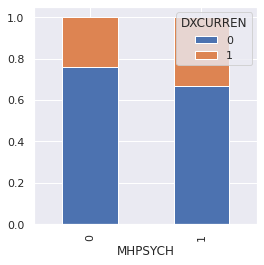

In [53]:
a = df[df.MHPSYCH != -4]
Rh=pd.crosstab(a['MHPSYCH'],a['DXCURREN'])
Rh.div(Rh.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.show()

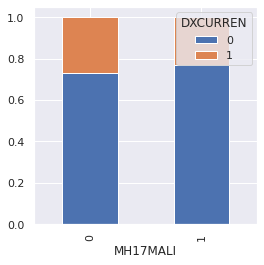

In [54]:
a = df[df.MH17MALI != -4]
Rh=pd.crosstab(a['MH17MALI'],a['DXCURREN'])
Rh.div(Rh.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.show()

(15.3, 24.0)

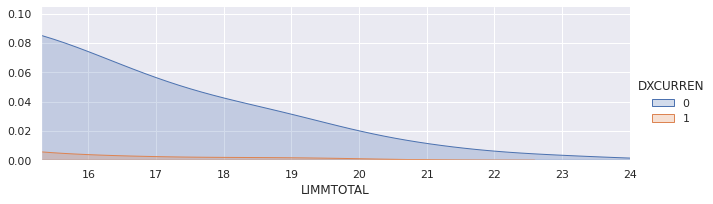

In [55]:
#MMSE : Mini Mental State Examination
facet= sns.FacetGrid(df,hue="DXCURREN", aspect=3)
facet.map(sns.kdeplot,'LIMMTOTAL',shade= True)
facet.set(xlim=(0, df['LIMMTOTAL'].max()))
facet.add_legend()
plt.xlim(15.30)

(15.3, 23.0)

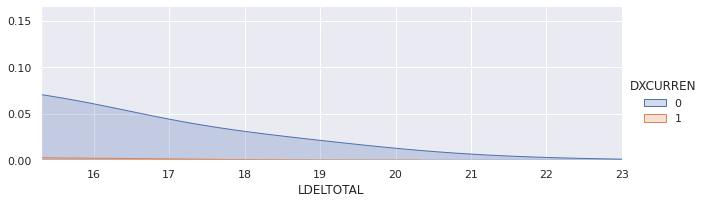

In [56]:
#MMSE : LDELTOTAL delayed recall
facet= sns.FacetGrid(df,hue="DXCURREN", aspect=3)
facet.map(sns.kdeplot,'LDELTOTAL',shade= True)
facet.set(xlim=(0, df['LDELTOTAL'].max()))
facet.add_legend()
plt.xlim(15.30)

# the plot above tells that patients who are of good health have a good 
# immediate and delayed  recall score than for the mci and ad patients

(15.3, 2033.056)

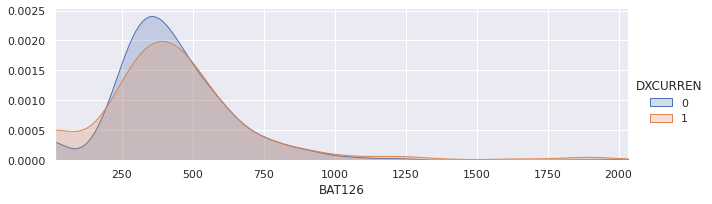

In [57]:
# :AXT117
facet= sns.FacetGrid(df,hue="DXCURREN", aspect=3)
facet.map(sns.kdeplot,'BAT126',shade= True)
facet.set(xlim=(0, df['BAT126'].max()))
facet.add_legend()
plt.xlim(15.30)

(15.3, 367.31699999999995)

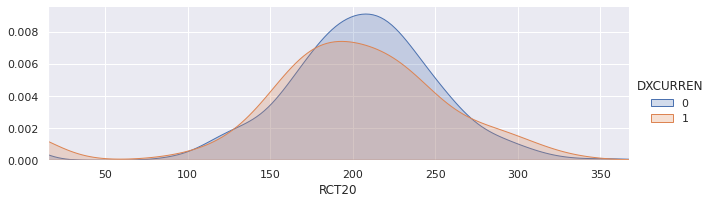

In [58]:
# :AXT117
facet= sns.FacetGrid(df,hue="DXCURREN", aspect=3)
facet.map(sns.kdeplot,'RCT20',shade= True)
facet.set(xlim=(0, df['RCT20'].max()))
facet.add_legend()
plt.xlim(15.30)

 17 features were selected out of a pool of 30 features the remaining 13 had low predicting power removing them increased the performance of the model. 
 whish are 'RCT11', 'HMT40', 'RCT6', 'HMT13', 'MH9ENDO', 'LIMMTOTAL', 'MMSCORE', 'AXT117', 'RCT392', 'HMT100', 'HMT7', 'age', 'CDGLOBAL', 'BAT126', 'HMT102', 'LDELTOTAL', 'RCT20'

In [59]:
features_selected = df[['RCT11', 'HMT40', 'RCT6', 'HMT13', 'MH9ENDO', 'LIMMTOTAL', 'MMSCORE', 'AXT117', 'RCT392', 'HMT100', 'HMT7', 'age', 'CDGLOBAL', 'BAT126', 'HMT102', 'LDELTOTAL', 'RCT20']]

In [60]:
features_selected.columns

Index(['RCT11', 'HMT40', 'RCT6', 'HMT13', 'MH9ENDO', 'LIMMTOTAL', 'MMSCORE',
       'AXT117', 'RCT392', 'HMT100', 'HMT7', 'age', 'CDGLOBAL', 'BAT126',
       'HMT102', 'LDELTOTAL', 'RCT20'],
      dtype='object')

In [62]:
features_selected.head()

,RCT11,HMT40,RCT6,HMT13,MH9ENDO,LIMMTOTAL,MMSCORE,AXT117,RCT392,HMT100,HMT7,age,CDGLOBAL,BAT126,HMT102,LDELTOTAL,RCT20
0,90.080,14.4,37.844,220.0,0,16,30,1.26,0.916,32.8,5.5,80,0.0,483.867,34.3,14,173.993
1,88.278,14.9,51.059,190.0,0,14,30,1.01,0.928,32.7,4.6,80,0.0,397.123,34.4,15,181.726
2,129.715,12.6,18.021,254.0,0,9,30,1.31,0.792,32.5,5.2,82,0.0,402.545,34.2,11,251.322
3,97.286,12.4,23.427,311.0,0,14,28,2.15,0.792,31.8,5.6,82,0.0,435.074,33.8,13,266.788
4,90.080,12.3,25.830,226.0,0,9,27,1.94,0.735,32.7,4.0,82,0.0,349.685,33.9,11,301.587
